# Using `pandas` with `dataframe-haystack`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EdAbati/dataframes-haystack/blob/main/notebooks/pandas-example.ipynb)


In [1]:
# when running in Google Colab (or similar), install the following packages
# !pip install dataframe-haystack arxiv

In [2]:
import pandas as pd

## Downloading the dataset

We are using a dataset that contains abstracts of papers uploaded on arXiv. We are using the arXiv API to get the data.

In [3]:
def get_arxiv_data(search_query: str, max_num_rows: int = 10) -> pd.DataFrame:
    """Get data using the arXiv API."""
    import arxiv

    arxiv_client = arxiv.Client()

    search = arxiv.Search(query=search_query, max_results=max_num_rows, sort_by=arxiv.SortCriterion.Relevance)
    results_list = [
        {
            "title": result.title,
            "authors": [author.name for author in result.authors],
            "summary": result.summary,
            "published": result.published,
            "primary_category": result.primary_category,
            "categories": result.categories,
            "pdf_url": result.pdf_url,
            "entry_id": result.entry_id,
        }
        for result in arxiv_client.results(search)
    ]
    return pd.DataFrame(results_list)

We will have a dataset of 10 rows with papers about LLMs.

In [4]:
df = get_arxiv_data("llm", max_num_rows=10)
df.head()

,title,authors,summary,published,primary_category,categories,pdf_url,entry_id
0,Large Language Models as Software Components: ...,[Irene Weber],Large Language Models (LLMs) have become widel...,2024-06-13 21:32:56+00:00,cs.SE,"[cs.SE, cs.CL, cs.LG, A.1; I.2.7; D.2.11]",http://arxiv.org/pdf/2406.10300v1,http://arxiv.org/abs/2406.10300v1
1,Parrot: Efficient Serving of LLM-based Applica...,"[Chaofan Lin, Zhenhua Han, Chengruidong Zhang,...",The rise of large language models (LLMs) has e...,2024-05-30 09:46:36+00:00,cs.LG,"[cs.LG, cs.AI]",http://arxiv.org/pdf/2405.19888v1,http://arxiv.org/abs/2405.19888v1
2,A Survey of Large Language Models for Code: Ev...,"[Zibin Zheng, Kaiwen Ning, Yanlin Wang, Jingwe...","General large language models (LLMs), represen...",2023-11-17 07:55:16+00:00,cs.SE,[cs.SE],http://arxiv.org/pdf/2311.10372v2,http://arxiv.org/abs/2311.10372v2
3,A Survey of Large Language Models on Generativ...,"[Wenbo Shang, Xin Huang]",A graph is a fundamental data model to represe...,2024-04-23 07:39:24+00:00,cs.CL,"[cs.CL, cs.AI, cs.DB]",http://arxiv.org/pdf/2404.14809v1,http://arxiv.org/abs/2404.14809v1
4,TEST: Text Prototype Aligned Embedding to Acti...,"[Chenxi Sun, Hongyan Li, Yaliang Li, Shenda Hong]",This work summarizes two ways to accomplish Ti...,2023-08-16 09:16:02+00:00,cs.CL,"[cs.CL, cs.AI]",http://arxiv.org/pdf/2308.08241v2,http://arxiv.org/abs/2308.08241v2


Saving the data in a temporary file.

In [5]:
import tempfile

# create a temporary file
temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".csv")

# write the dataframe to the temporary file
with open(temp_file.name, "w") as f:
    df.to_csv(f, index=False)

## Loading the data in `haystack`

We can read the data using a `FileToPandasDataFrame` and convert the rows into `Document`s using a `PandasDataFrameConverter` component.

In [6]:
from dataframes_haystack.components.converters.pandas import FileToPandasDataFrame, PandasDataFrameConverter

In [7]:
file_to_pandas = FileToPandasDataFrame(file_format="csv")

In [8]:
output_dataframe = file_to_pandas.run(file_paths=[temp_file.name])

In [9]:
# the output_dataframe is a dictionary with a dataframe key
output_dataframe.keys()

dict_keys(['dataframe'])

In [10]:
output_dataframe["dataframe"].head()

,title,authors,summary,published,primary_category,categories,pdf_url,entry_id
0,Large Language Models as Software Components: ...,['Irene Weber'],Large Language Models (LLMs) have become widel...,2024-06-13 21:32:56+00:00,cs.SE,"['cs.SE', 'cs.CL', 'cs.LG', 'A.1; I.2.7; D.2.11']",http://arxiv.org/pdf/2406.10300v1,http://arxiv.org/abs/2406.10300v1
1,Parrot: Efficient Serving of LLM-based Applica...,"['Chaofan Lin', 'Zhenhua Han', 'Chengruidong Z...",The rise of large language models (LLMs) has e...,2024-05-30 09:46:36+00:00,cs.LG,"['cs.LG', 'cs.AI']",http://arxiv.org/pdf/2405.19888v1,http://arxiv.org/abs/2405.19888v1
2,A Survey of Large Language Models for Code: Ev...,"['Zibin Zheng', 'Kaiwen Ning', 'Yanlin Wang', ...","General large language models (LLMs), represen...",2023-11-17 07:55:16+00:00,cs.SE,['cs.SE'],http://arxiv.org/pdf/2311.10372v2,http://arxiv.org/abs/2311.10372v2
3,A Survey of Large Language Models on Generativ...,"['Wenbo Shang', 'Xin Huang']",A graph is a fundamental data model to represe...,2024-04-23 07:39:24+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.DB']",http://arxiv.org/pdf/2404.14809v1,http://arxiv.org/abs/2404.14809v1
4,TEST: Text Prototype Aligned Embedding to Acti...,"['Chenxi Sun', 'Hongyan Li', 'Yaliang Li', 'Sh...",This work summarizes two ways to accomplish Ti...,2023-08-16 09:16:02+00:00,cs.CL,"['cs.CL', 'cs.AI']",http://arxiv.org/pdf/2308.08241v2,http://arxiv.org/abs/2308.08241v2


In [11]:
pandas_converter = PandasDataFrameConverter(
    content_column="summary",
    meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
)

In [12]:
pandas_converter.run(dataframe=output_dataframe["dataframe"])

{'documents': [Document(id=9cc8974e10748c08b9dceaa8c30d43f669be68507bb894de7dc7859705405413, content: 'Large Language Models (LLMs) have become widely adopted recently. Research
  explores their use both a...', meta: {'title': 'Large Language Models as Software Components: A Taxonomy for LLM-Integrated Applications', 'authors': "['Irene Weber']", 'published': '2024-06-13 21:32:56+00:00', 'primary_category': 'cs.SE', 'categories': "['cs.SE', 'cs.CL', 'cs.LG', 'A.1; I.2.7; D.2.11']", 'pdf_url': 'http://arxiv.org/pdf/2406.10300v1'}),
  Document(id=f90081e94dc913433a91bb8e77e6179a9d63749891f9215fc1c9e2627995e152, content: 'The rise of large language models (LLMs) has enabled LLM-based applications
  (a.k.a. AI agents or co-...', meta: {'title': 'Parrot: Efficient Serving of LLM-based Applications with Semantic Variable', 'authors': "['Chaofan Lin', 'Zhenhua Han', 'Chengruidong Zhang', 'Yuqing Yang', 'Fan Yang', 'Chen Chen', 'Lili Qiu']", 'published': '2024-05-30 09:46:36+00:00', 'primary_c

If we want to use the dataframe index as unique identifier for documents, we can set the `use_index_as_id` parameter.

In [13]:
pandas_converter = PandasDataFrameConverter(
    content_column="summary",
    meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
    use_index_as_id=True,
)
pandas_converter.run(dataframe=output_dataframe["dataframe"])

{'documents': [Document(id=0, content: 'Large Language Models (LLMs) have become widely adopted recently. Research
  explores their use both a...', meta: {'title': 'Large Language Models as Software Components: A Taxonomy for LLM-Integrated Applications', 'authors': "['Irene Weber']", 'published': '2024-06-13 21:32:56+00:00', 'primary_category': 'cs.SE', 'categories': "['cs.SE', 'cs.CL', 'cs.LG', 'A.1; I.2.7; D.2.11']", 'pdf_url': 'http://arxiv.org/pdf/2406.10300v1'}),
  Document(id=1, content: 'The rise of large language models (LLMs) has enabled LLM-based applications
  (a.k.a. AI agents or co-...', meta: {'title': 'Parrot: Efficient Serving of LLM-based Applications with Semantic Variable', 'authors': "['Chaofan Lin', 'Zhenhua Han', 'Chengruidong Zhang', 'Yuqing Yang', 'Fan Yang', 'Chen Chen', 'Lili Qiu']", 'published': '2024-05-30 09:46:36+00:00', 'primary_category': 'cs.LG', 'categories': "['cs.LG', 'cs.AI']", 'pdf_url': 'http://arxiv.org/pdf/2405.19888v1'}),
  Document(id=2, cont

### Using the components in a pipeline

In [14]:
from haystack import Pipeline
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

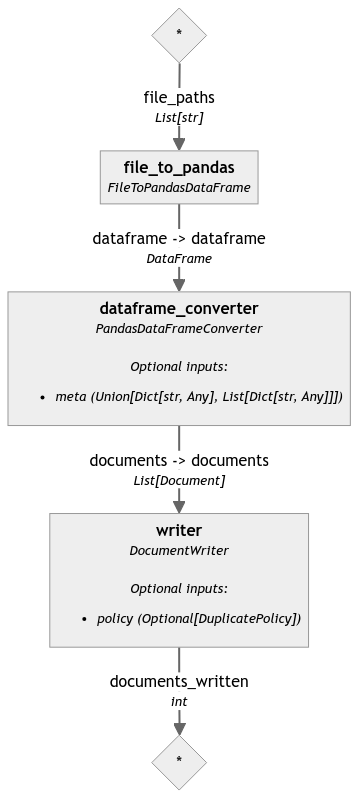

In [15]:
document_store = InMemoryDocumentStore()

indexing = Pipeline()
indexing.add_component("file_to_pandas", FileToPandasDataFrame(file_format="csv"))
indexing.add_component(
    "dataframe_converter",
    PandasDataFrameConverter(
        content_column="summary",
        meta_columns=["title", "authors", "published", "primary_category", "categories", "pdf_url"],
    ),
)
indexing.add_component("writer", DocumentWriter(document_store))
indexing.connect("file_to_pandas", "dataframe_converter")
indexing.connect("dataframe_converter", "writer")
indexing.show()

In [16]:
indexing.run({"file_to_pandas": {"file_paths": [temp_file.name]}})

{'writer': {'documents_written': 10}}

In [17]:
# Cleanup
# delete the temporary file
from pathlib import Path

Path(temp_file.name).unlink()